In [1]:
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from tqdm import tqdm
from matplotlib.animation import FuncAnimation, FFMpegFileWriter

In [2]:
FWC = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWC_full_domain.nc')['__xarray_dataarray_variable__'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
depth_no_nan = depth
depth = depth.where(depth > 0, np.nan)

display(FWC)

<xarray.DataArray '__xarray_dataarray_variable__' (time: 1460, Y: 628, X: 765)>
[701413200 values with dtype=float64]
Coordinates:
  * X        (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.62 11.72 11.82 11.92
  * Y        (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2017-09-01 ... 2018-08-31T18:00:00

In [3]:
FWC_mean = FWC.mean(dim='time')
FWC_var = FWC.var(dim='time')

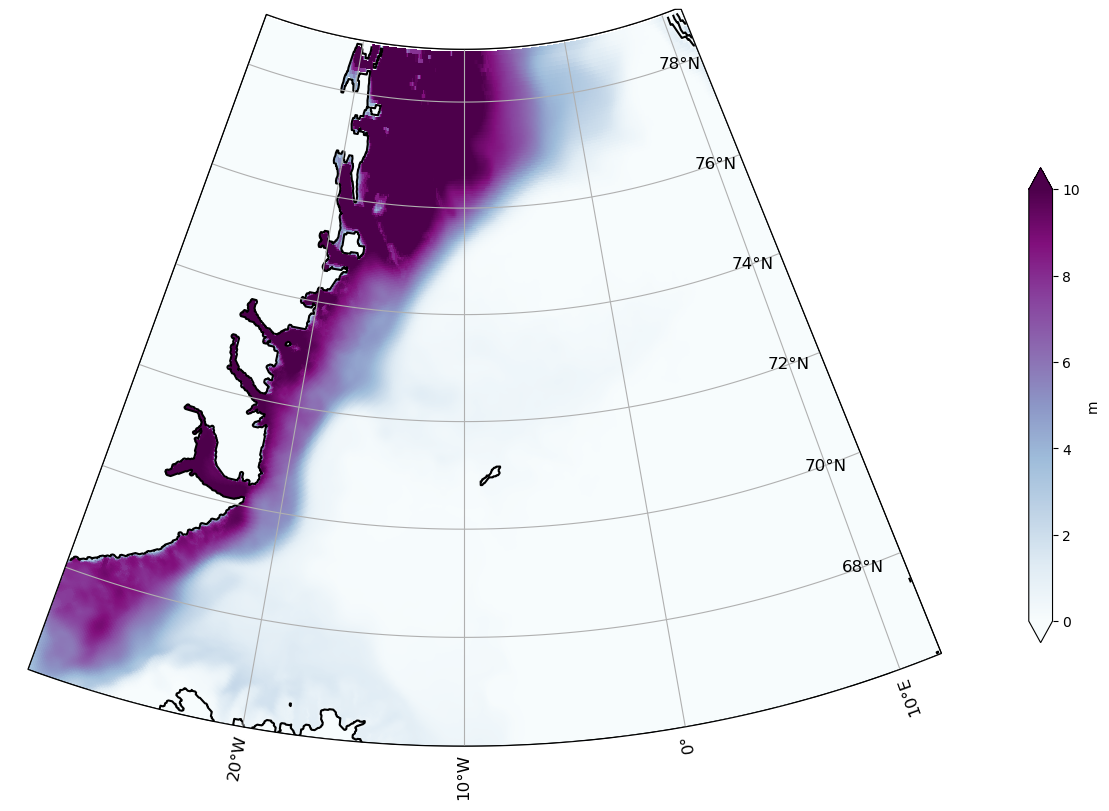

In [4]:
# Function to create a LineCollection
def create_line_collection_with_edgecolor(XC, YC, FWT_N, cmap, linewidth=5, edgecolor='black', edgewidth=7, edge_alpha=0.5):
    # Create line segments
    points = np.array([XC, YC]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create the edge line collection
    edge_lc = LineCollection(segments, colors=[edgecolor], linewidths=edgewidth, alpha=edge_alpha, transform=ccrs.PlateCarree())

    # Create the main line collection
    main_lc = LineCollection(segments, cmap=cmap, transform=ccrs.PlateCarree())
    main_lc.set_array(np.array(FWT_N))
    main_lc.set_linewidth(linewidth)
    
    return edge_lc, main_lc



# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-30+10, 12+10, 66, 79]
vmin=0
vmax=10

# Example data for testing
lon = depth['XC']
lat = depth['YC']
cmap = plt.get_cmap('BuPu')
mesh = ax.pcolormesh(FWC_mean.X, FWC_mean.Y, FWC_mean, cmap=cmap,vmin=vmin,vmax=vmax, transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh, shrink=0.6, extend='both')
cbar.set_label('m')

# Add land contour
ax.contour(lon, lat, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())



# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# Add the combined legend
# ax.legend(loc='upper right', prop={"size": 15})

# Show the plot
plt.draw()

# Save the figure
plt.savefig(r'/nird/home/ekv036/MSc/Fig/ModelFWC',dpi=300, bbox_inches='tight', pad_inches=0.1)

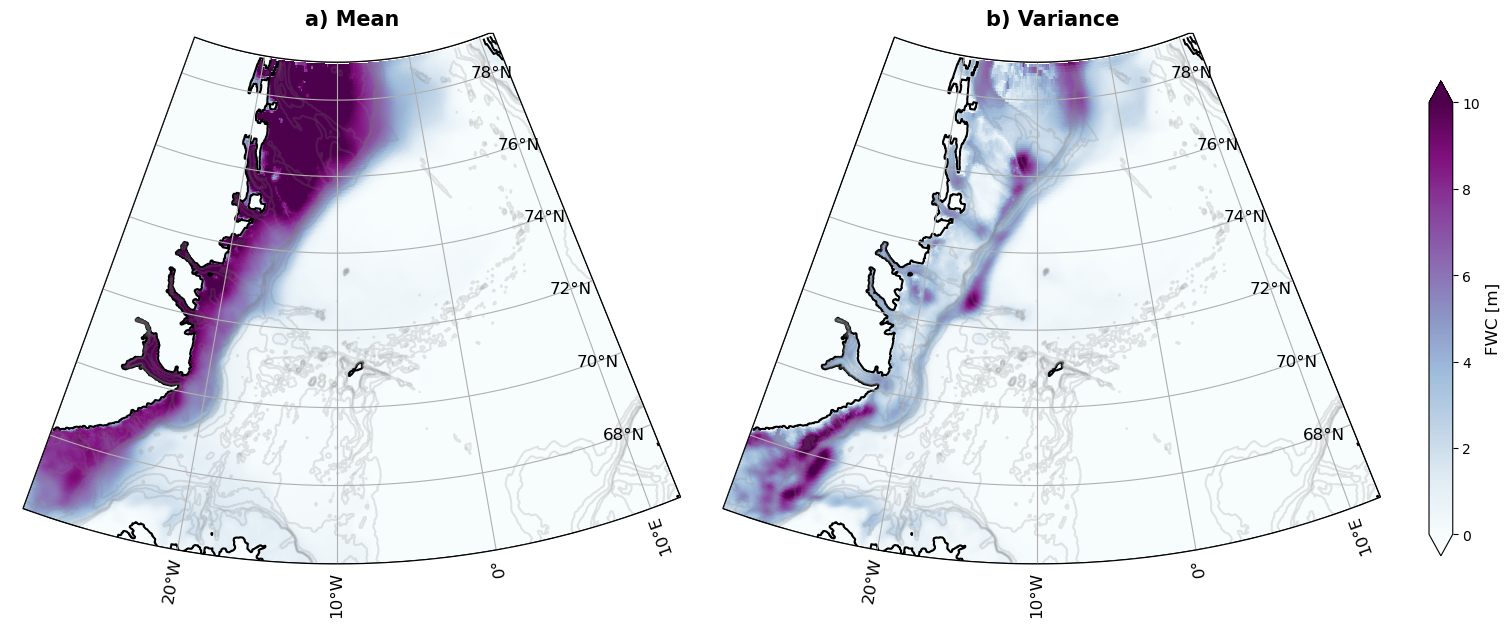

In [5]:
# Assuming depth, res, res_smooth, X, and Y are already defined in your Jupyter notebook

lon = depth['XC']
lat = depth['YC']

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, axs = plt.subplot_mosaic([[1,2]], figsize=(15, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-30+10, 12+10, 66, 79]
vmin=0
vmax=10

# Plot the data using pcolormesh without normalization
pcm1 = axs[1].pcolormesh(FWC_mean.X, FWC_mean.Y, FWC_mean, cmap=cmap,vmin=vmin,vmax=vmax, transform=ccrs.PlateCarree())
# Add land contour
axs[1].contour(lon, lat, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs[1].contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

# Plot the data using pcolormesh without normalization
pcm2 = axs[2].pcolormesh(FWC_var.X, FWC_var.Y, FWC_var, cmap=cmap,vmin=vmin,vmax=vmax, transform=ccrs.PlateCarree())
# Add land contour
axs[2].contour(lon, lat, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs[2].contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm1, ax=axs[2], shrink=0.6, extend='both')
cbar.set_label('FWC [m]', fontsize=12)

axs[1].set_title('a) Mean', fontsize=15, fontweight='bold')
axs[2].set_title('b) Variance', fontsize=15, fontweight='bold')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs[1].transData, edgecolor='black', facecolor='none')
axs[1].add_patch(patch)
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path =path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs[2].transData, edgecolor='black', facecolor='none')
axs[2].add_patch(patch)

# Set the boundary using the transformed path
axs[1].set_boundary(patch.get_path(), transform=axs[1].transData)
axs[2].set_boundary(patch.get_path(), transform=axs[2].transData)

# Add gridlines and labels
gl = axs[1].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

gl = axs[2].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# Save the figure
plt.savefig(r'/nird/home/ekv036/MSc/Fig/FWC_mean_var')


In [6]:
# Animation of FWC through year for each month
FWC_month_mean = FWC.resample(time='ME').mean(dim='time')
FWC_month_var = FWC.resample(time='ME').var(dim='time')

Generating Frames: 25it [01:16,  3.08s/it]                        


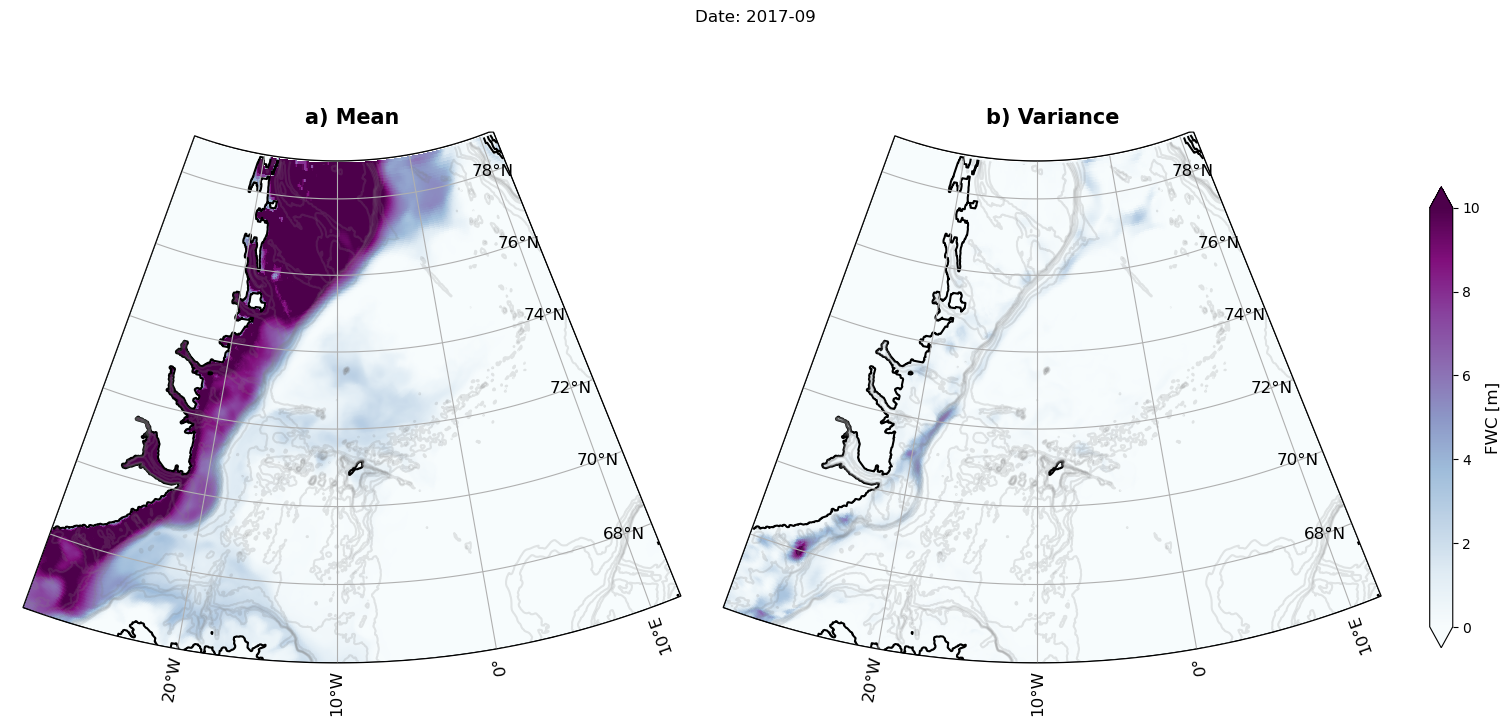

In [7]:
# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, axs = plt.subplot_mosaic([[1,2]], figsize=(15, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-30+10, 12+10, 66, 79]
vmin=0
vmax=10

# Plot the data using pcolormesh without normalization
pcm1 = axs[1].pcolormesh(FWC_mean.X, FWC_mean.Y, FWC_month_mean[0], cmap=cmap,vmin=vmin,vmax=vmax, transform=ccrs.PlateCarree())
# Add land contour
axs[1].contour(lon, lat, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs[1].contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

# Plot the data using pcolormesh without normalization
pcm2 = axs[2].pcolormesh(FWC_var.X, FWC_var.Y, FWC_month_var[0], cmap=cmap,vmin=vmin,vmax=vmax, transform=ccrs.PlateCarree())
# Add land contour
axs[2].contour(lon, lat, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs[2].contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm1, ax=axs[2], shrink=0.6, extend='both')
cbar.set_label('FWC [m]', fontsize=12)

axs[1].set_title('a) Mean', fontsize=15, fontweight='bold')
axs[2].set_title('b) Variance', fontsize=15, fontweight='bold')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs[1].transData, edgecolor='black', facecolor='none')
axs[1].add_patch(patch)
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path =path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs[2].transData, edgecolor='black', facecolor='none')
axs[2].add_patch(patch)

# Set the boundary using the transformed path
axs[1].set_boundary(patch.get_path(), transform=axs[1].transData)
axs[2].set_boundary(patch.get_path(), transform=axs[2].transData)

# Add gridlines and labels
gl = axs[1].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

gl = axs[2].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}
fig.suptitle(f'Date: {str(FWC_month_mean.time.values[0])[0:7]}')

T = len(FWC_month_mean.time)
pbar = tqdm(total=T, desc="Generating Frames")

def update_plot(frame):
    axs[1].clear()
    axs[2].clear()
    axs[1].set_title('a) Mean', fontsize=15, fontweight='bold')
    axs[2].set_title('b) Variance', fontsize=15, fontweight='bold')
    fig.suptitle(f'Date: {str(FWC_month_mean.time.values[frame])[0:7]}')
    
    axs[1].pcolormesh(FWC_mean.X, FWC_mean.Y, FWC_month_mean[frame], cmap=cmap,vmin=vmin,vmax=vmax, transform=ccrs.PlateCarree())
    axs[2].pcolormesh(FWC_var.X, FWC_var.Y, FWC_month_var[frame], cmap=cmap,vmin=vmin,vmax=vmax, transform=ccrs.PlateCarree())
    
    axs[1].contour(lon, lat, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
    axs[1].contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())
    axs[2].contour(lon, lat, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
    axs[2].contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

    # cbar = fig.colorbar(pcm1, ax=axs[2], shrink=0.6, extend='both')
    # cbar.set_label('FWC [m]', fontsize=12)
    
    # Create a custom path for the extent in PlateCarree projection
    num_points = 100
    bottom_lons = np.linspace(extent[0], extent[1], num_points)
    top_lons = np.linspace(extent[1], extent[0], num_points)
    bottom_lats = np.full_like(bottom_lons, extent[2])
    top_lats = np.full_like(top_lons, extent[3])

    # Combine the vertices
    verts = np.vstack([
        np.column_stack([bottom_lons, bottom_lats]),
        np.column_stack([top_lons, top_lats])
    ])

    # Transform the vertices to the NorthPolarStereo projection
    proj = ccrs.NorthPolarStereo()
    verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
    verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

    # Create the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=axs[1].transData, edgecolor='black', facecolor='none')
    axs[1].add_patch(patch)
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path =path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=axs[2].transData, edgecolor='black', facecolor='none')
    axs[2].add_patch(patch)

    # Set the boundary using the transformed path
    axs[1].set_boundary(patch.get_path(), transform=axs[1].transData)
    axs[2].set_boundary(patch.get_path(), transform=axs[2].transData)

    # Add gridlines and labels
    gl = axs[1].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    gl = axs[2].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    pbar.update(1)

ani = FuncAnimation(fig, update_plot, frames=T, interval=1000)
ani.save(r'/nird/home/ekv036/MSc/Animations/FWC.gif', writer='pillow', progress_callback=lambda i, n: pbar.update(1))
pbar.close()